# ML Starting...

##### El sistema de recomendacion esta hecho para el acompañamiento en la toma de desiciones por parte de inversionistas del la industria gastronomica, en base a: si invertir, o no, en un conjugado de características contenidas en su plan de inversion para el futuro negocio a emplazar.

- Ubicacion (State; City)
- Categoría (Mexican Food; Fast Food, etc..)
- Atributos  (Parking; Wheelchair; Petfriendly, etc...) YELP (Disponible) 
- Servcicios (Parking; Wheelchair; Petfriendly, etc...) gm_misc (Places API... Verificando posibilidad...)
- Cálculo del volumen de estrellasrecibido (eda_yelp_reviews_full)
- Reseñas de los usuarios (Perseption of public resume) - Resumen Usuarios perspectiva
- Horarios de apertura y cierrre (Opcional segun tiempos deadline)
- Descripcion (Opcional NLP; segun tiempos deadline) 

## Importo Solo los datasets necesarios:

#### Para ello se necesitan los datasets:


- Ubicacion y datos generales (eda_yelp_bussines.parquet) - "main"
- Categoría (eda_yelp_bussines.parquet) - "main"
- Atributos = Servcicios (eda_yelp_bussines.parquet) - "main"
- Cálculo del volumen de estrellasrecibido (eda_yelp_reviews_full)
- Reseñas de los usuarios (eda_yelp_reviews_2018_to_2020.parquet + yelp_reviews_2021_to_2022.parquet + yelp_user.parquet ) 
- #Horarios de apertura y cierrre (gmap)
- #Descripcion (gmap)

### Import Libraries:

In [1]:
#!pip install transformer

In [2]:
#!pip install tensorflow

In [3]:
import pandas as pd
import missingno as msno
import seaborn as sns

## Estudio datasets:

#### eda_yelp_bussines:

In [17]:
eda_yelp_business = pd.read_parquet('../../../Eda_datasets/eda_yelp_bussines.parquet')

In [18]:
# Eliminar las columnas "latitude" y "longitude"
columnas_a_eliminar = ['latitude', 'longitude','state','address']
eda_yelp_business = eda_yelp_business.drop(columnas_a_eliminar, axis=1)

In [19]:
eda_yelp_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132342 entries, 0 to 132341
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   132342 non-null  object 
 1   name          132342 non-null  object 
 2   city          132342 non-null  object 
 3   stars         132342 non-null  float64
 4   review_count  132342 non-null  int64  
 5   attributes    132342 non-null  object 
 6   categories    132342 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 7.1+ MB


In [20]:
eda_yelp_business.head()

,business_id,name,city,stars,review_count,attributes,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food"
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,Brentwood,2.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping..."
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,3.0,19,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...","Pubs, Restaurants, Italian, Bars, American (Tr..."


##### Separar las CATEGORÍAS para conocer su frecuencia: Listado categorias frecuencia:

In [26]:
# Separar las categorías y contar su frecuencia
categories_counts = {}
for categories in eda_yelp_business['categories']:
    categories_list = categories.split(', ')
    for category in categories_list:
        categories_counts[category] = categories_counts.get(category, 0) + 1

# Crear un DataFrame a partir del diccionario de categorías y frecuencias
categories_df = pd.DataFrame(list(categories_counts.items()), columns=['Category', 'Frequency'])

# Ordenar el DataFrame por frecuencia en orden descendente
categories_df = categories_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)


In [31]:
# Mostrar el DataFrame resultante
categories_df.head()

,Category,Frequency
0,Restaurants,51291
1,Food,26714
2,Shopping,22990
3,Beauty & Spas,13614
4,Nightlife,12141


In [30]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Category   1298 non-null   object
 1   Frequency  1298 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


##### Separar las ATTRIBUTES para conocer su frecuencia: Listado attributes frecuencia:

In [32]:

# Crear un diccionario para almacenar la cantidad de valores True para cada clave en attributes
attribute_counts = {}

# Iterar sobre cada entrada en la columna attributes
for attr in eda_yelp_business['attributes']:
    # Convertir la entrada a un diccionario
    attr_dict = eval(attr)  # Se asume que los datos están en formato string de diccionario

    # Iterar sobre cada clave y valor en el diccionario
    for key, value in attr_dict.items():
        # Si el valor es True, incrementar la cuenta para esa clave
        if value == 'True':
            attribute_counts[key] = attribute_counts.get(key, 0) + 1

# Crear un DataFrame a partir del diccionario de counts
attributes_df = pd.DataFrame(list(attribute_counts.items()), columns=['Attribute', 'True_Count'])

# Ordenar el DataFrame por cantidad de True en orden descendente
attributes_df = attributes_df.sort_values(by='True_Count', ascending=False).reset_index(drop=True)


In [33]:

# Mostrar el DataFrame resultante
attributes_df.head()

,Attribute,True_Count
0,BusinessAcceptsCreditCards,110396
1,BikeParking,54612
2,RestaurantsTakeOut,52558
3,GoodForKids,43519
4,RestaurantsGoodForGroups,37953


In [34]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attribute   24 non-null     object
 1   True_Count  24 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


##### Simpli EDA of yelp_business:

<Axes: >

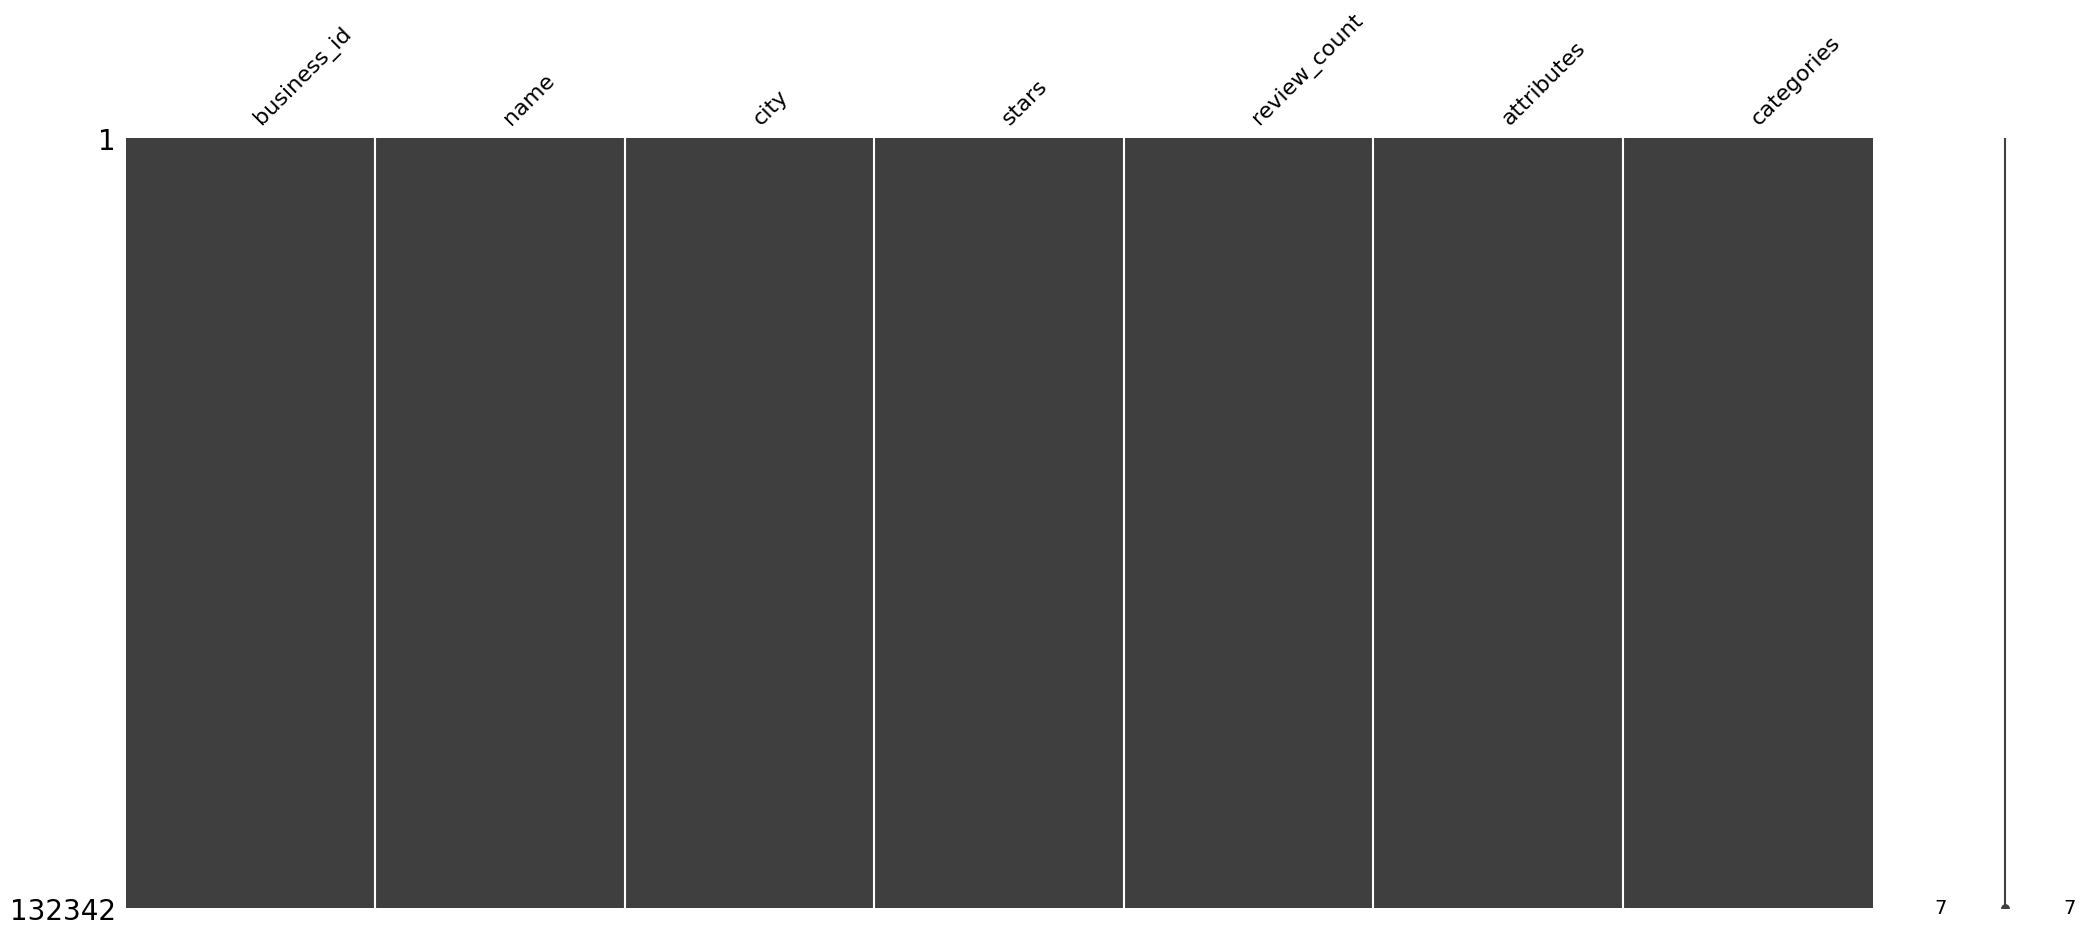

In [21]:
msno.matrix(eda_yelp_business)

### eda_yelp_reviews_2018_to_2020:

In [9]:
eda_yelp_reviews_2018_to_2020 = pd.read_parquet('../../../Eda_datasets/eda_yelp_reviews_2018_to_2020.parquet')

In [10]:
eda_yelp_reviews_2018_to_2020.head(10)

,review_id,user_id,business_id,stars,useful,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,"If you decide to eat here, just be aware it is...",2018-07-07
1,lUUhg8ltDsUZ9h0xnwY4Dg,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4,1,1,I was really between 3 and 4 stars for this on...,2018-07-17
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23
3,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27
4,A4n4YaE-owOVgTQcrVqHUw,S7bjj-L07JuRr-tpX1UZLw,I6L0Zxi5Ww0zEWSAVgngeQ,4,0,0,The cafe was extremely cute. We came at 8am an...,2018-07-07
5,4KpIldEM-tdnrJLqYzRfZQ,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,5,1,1,I've only had the cannolis here but they are a...,2018-03-23
6,meGaFP7yxQdjyABrYDVeoQ,_jaJDV-qTBafatbObmtzpA,cg4JFJcCxRTTMmcg9O9KtA,1,0,0,Skip this train wreck if you are looking for d...,2018-02-11
7,tXHWJWnTdrraHGUqaPWj3g,zKAHSNzqvwsyoFCw3QpafA,S2Ho8yLxhKAa26pBAm6rxA,4,0,0,Enjoyed my fish out at a sidewalk table. A bi...,2018-05-19
8,r1tPwFMILy0COeEQ-B3YLw,3M1_pyDSgMP6sRMz564eJw,8xM8akbQhHDQdJO1sPMB1A,5,0,0,I had the pleasure to meet with Ann today and ...,2018-07-26
9,zcj7iTXdSz0GCBOReMTeiQ,X8XCFMZN8pFlWEZcKuKzZw,Zx7n8mdt8OzLRXVzolXNhQ,5,0,0,A menu that satisfies everyone's cravings! Cle...,2018-01-21


### eda_yelp_reviews_2021_to_2022:

In [11]:
eda_yelp_reviews_2021_to_2022 = pd.read_parquet('../../../Eda_datasets/eda_yelp_reviews_2021_to_2022.parquet')

In [12]:
eda_yelp_reviews_2021_to_2022.head(10)

,review_id,user_id,business_id,stars,useful,cool,text,date
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5,0,0,I've been eating at this restaurant for over 5...,2021-01-08
1,HgEofz6qEQqKYPT7YLA34w,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1,0,0,How does a delivery person from here get lost ...,2021-01-02
2,milJ7UH4Od9pBe2gWac9tA,v7i4M7NIx3bMNMChaXjU7Q,raKflkp3CANr8N7qpQ3ZyQ,5,0,0,I WISH I was still a Sierra resident. They're ...,2021-02-02
3,Kxo5d6EOnOE-vERwQf2a1w,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5,0,0,"The service is always good, the employees are ...",2021-01-26
4,STqHwh6xd05bgS6FoAgRqw,j4qNLF-VNRF2DwBkUENW-w,yE1raqkLX7OZsjmX3qKIKg,5,0,0,two words: whipped. feta. \nexplosion of amazi...,2021-01-27
5,u0smrr16uVQ8pgSEseXcKg,H3P9EB7J9HP6PzkVjgFiOg,oQ5CPRt0R3AzFvcjNOqB1w,5,0,0,So day 2 in Nashville. I gotta get some BBQ. M...,2021-03-17
6,75Ckhq13s7k-crts_0MY9g,h41RIr5Rtkq7EoJ0tU0wgQ,3PlpoDgeAQAreL8FM2LelA,4,0,0,Place was great as well as parking. \nFood was...,2021-01-30
7,L1Gxa_8r8D7wfXNUvopucg,nXFY3pJX7HopSTBqhfUziQ,sZpCsqIbCfHr-CziYw-O1g,5,0,0,"This salon is pretty busy, so it's a good idea...",2021-03-12
8,N0Dq5TPfMuf13PB6p9rtYw,DKoZaUmK18zmMU6kR2H85A,NDHgJsy-4Lb6WhERPXPs0A,5,0,0,I happened upon this coffee shop while looking...,2021-01-21
9,75gDbguyv0SAYjD2XeKDtg,HZow1indN8C-FnbMcDtjfg,-yA8WOM8oYYmEIwYC2JeWQ,5,0,0,Grundy was easy to communicate with and althou...,2021-01-06


### Concat eda_yelp_reviews_full:

In [13]:
# Concatenar los DataFrames
eda_yelp_reviews_full = pd.concat([eda_yelp_reviews_2018_to_2020, eda_yelp_reviews_2021_to_2022], ignore_index=True)

In [14]:
# Mostrar el DataFrame concatenado
eda_yelp_reviews_full.head(10)

,review_id,user_id,business_id,stars,useful,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,"If you decide to eat here, just be aware it is...",2018-07-07
1,lUUhg8ltDsUZ9h0xnwY4Dg,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4,1,1,I was really between 3 and 4 stars for this on...,2018-07-17
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23
3,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27
4,A4n4YaE-owOVgTQcrVqHUw,S7bjj-L07JuRr-tpX1UZLw,I6L0Zxi5Ww0zEWSAVgngeQ,4,0,0,The cafe was extremely cute. We came at 8am an...,2018-07-07
5,4KpIldEM-tdnrJLqYzRfZQ,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,5,1,1,I've only had the cannolis here but they are a...,2018-03-23
6,meGaFP7yxQdjyABrYDVeoQ,_jaJDV-qTBafatbObmtzpA,cg4JFJcCxRTTMmcg9O9KtA,1,0,0,Skip this train wreck if you are looking for d...,2018-02-11
7,tXHWJWnTdrraHGUqaPWj3g,zKAHSNzqvwsyoFCw3QpafA,S2Ho8yLxhKAa26pBAm6rxA,4,0,0,Enjoyed my fish out at a sidewalk table. A bi...,2018-05-19
8,r1tPwFMILy0COeEQ-B3YLw,3M1_pyDSgMP6sRMz564eJw,8xM8akbQhHDQdJO1sPMB1A,5,0,0,I had the pleasure to meet with Ann today and ...,2018-07-26
9,zcj7iTXdSz0GCBOReMTeiQ,X8XCFMZN8pFlWEZcKuKzZw,Zx7n8mdt8OzLRXVzolXNhQ,5,0,0,A menu that satisfies everyone's cravings! Cle...,2018-01-21


### yelp_user:

In [15]:
yelp_user = pd.read_parquet('../../../Eda_datasets/eda_yelp_user.parquet')

In [16]:
yelp_user.tail(10)

,user_id,review_count,yelping_since,useful,cool,fans,average_stars
329164,FM2BqReuftlY6vSdNmIvhw,0,2022-01-19,0,0,0,5.0
329165,ezu7WPR_jotGYfvCXucjNg,3,2022-01-19,0,0,0,5.0
329166,KprFUD3kZghb0NC3VUWIGg,1,2022-01-19,0,0,0,1.0
329167,I-M6kAWQqC9nkITMopvqbA,1,2022-01-19,0,0,0,1.0
329168,1cCPvrlRTv7AgPwQOBAZPg,1,2022-01-19,0,0,0,1.0
329169,IaM7TRiBmwrgezg4ppBqpA,1,2022-01-19,0,0,0,1.0
329170,8f64yYInvWEzGnxEXgprzg,1,2022-01-19,0,0,0,5.0
329171,6uzx3jSpkuSA8gOk4bXAWw,1,2022-01-19,0,0,0,5.0
329172,jNwnKn1LVsDZrLB9YIxsog,1,2022-01-19,0,0,0,1.0
329173,yaRIVP9ndAt3GVPckPhGmA,1,2022-01-19,0,0,0,5.0


continuar analizando datasets;
Continuar con renombrar bien las carpetas y suplantar enlaces en el codigo ( quiza pueda quedar asi?)